# UrbanECG - Verifying Geometric Utils with Nexar Data + FloodNet 
Developer: @mattwfranchi, FARLAB @ Cornell Tech 

Last Edited: 12/06/2023

In [235]:
import os 
import sys 
from glob import glob 

sys.path.append('../')

from src.utils.logger import setup_logger 
logger = setup_logger("Verifying GeoUtils with Nexar + FloodNet")
logger.setLevel("INFO")

from src.utils.read_csv import read_csv

from user.params.data import COORD_CRS, PROJ_CRS, LONGITUDE_COL_311, LATITUDE_COL_311

from src.processing.geometric_utils import Frame

In [236]:
# Library Imports 
import pandas as pd 
import numpy as np 

from tqdm.auto import tqdm 
tqdm.pandas()

import geopandas as gpd 
from shapely import wkt
import osmnx as ox 

import matplotlib.pyplot as plt

In [180]:
FLOODNET_DATA = ["../data/nyc_flooding/floodnet-flood-sensor-oct-2023.csv"]

# frames + nearest edges assume same order
FLOODING_FRAMES = ["../output/street_flooding/df/2023-09-29/md.csv"]
FLOODING_NEAREST_EDGES = ["../output/street_flooding/df/2023-09-29/nearest_edges.csv"]

# 311 data 
FLOODING_REPORTS = ["../data/coords/sep29_flooding.csv"]
FLOODING_DESCRIPTORS = ["Street Flooding (SJ)", "Manhole Overflow (Use Comments) (SA1)", "Catch Basin Clogged/Flooding (Use Comments) (SC)", "Sewer Backup (Use Comments) (SA)"] 

NYC_CT_SHP = "../data/geo/nyc_ct/nyct2020.shp"
NYC_NTA_SHP = "../data/geo/nyc_nta/nynta2020.shp"
NYC_ROADS = "../data/geo/nyc.graphml"

In [181]:
# toggle latex plotting 
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

In [182]:
nyc_ct = gpd.read_file(NYC_CT_SHP).to_crs(PROJ_CRS)
nyc_nta = gpd.read_file(NYC_NTA_SHP).to_crs(PROJ_CRS)

nyc_roads = ox.io.load_graphml(NYC_ROADS)
nyc_roads_gdf = ox.utils_graph.graph_to_gdfs(nyc_roads, nodes=False, edges=True)

Text(0.5, 1.0, 'NYC Roads')

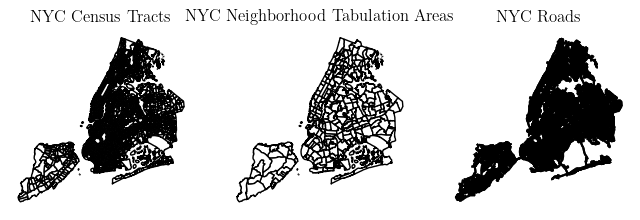

In [183]:
# Verification of geos, 3x1 subplot 
fig, ax = plt.subplots(1, 3, figsize=(8, 30))

# turn all axis off
for a in ax:
    a.axis('off')

# plot cts 
nyc_ct.plot(ax=ax[0], color='white', edgecolor='black')
ax[0].set_title("NYC Census Tracts")

# plot ntas
nyc_nta.plot(ax=ax[1], color='white', edgecolor='black')
ax[1].set_title("NYC Neighborhood Tabulation Areas")

# plot roads
nyc_roads_gdf.plot(ax=ax[2], color='black')
ax[2].set_title("NYC Roads")


In [217]:
floodnet_data = pd.concat([pd.read_csv(f, low_memory=False) for f in FLOODNET_DATA])

In [218]:
floodnet_data = floodnet_data.groupby('deployment_id').agg('first').reset_index(drop=True)

In [219]:
floodnet_data = gpd.GeoDataFrame(floodnet_data, geometry=gpd.points_from_xy(floodnet_data.lon, floodnet_data.lat), crs=COORD_CRS).to_crs(PROJ_CRS)

In [185]:
flooding_reports_data = pd.concat([pd.read_csv(f, low_memory=False) for f in FLOODING_REPORTS])
flooding_reports_data = flooding_reports_data[flooding_reports_data["Descriptor"].isin(FLOODING_DESCRIPTORS)].reset_index(drop=True)
flooding_reports_data = gpd.GeoDataFrame(flooding_reports_data, geometry=gpd.points_from_xy(flooding_reports_data[LONGITUDE_COL_311], flooding_reports_data[LATITUDE_COL_311]), crs=COORD_CRS).to_crs(PROJ_CRS)

In [186]:
# drop rows with empty geometry from flooding reports
len_before = len(flooding_reports_data)
flooding_reports_data = flooding_reports_data[~flooding_reports_data["geometry"].is_empty]
logger.info(f"Dropped {len_before - len(flooding_reports_data)} rows with empty geometry from flooding reports")

2023-12-06 12:42:14 - Verifying GeoUtils with Nexar + FloodNet - INFO - Dropped 11 rows with empty geometry from flooding reports


In [188]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
nyc_nta.plot(ax=ax, color='white', edgecolor='black', alpha=0.15)
flooding_reports_data.plot(ax=ax, cmap='Dark2', column='Descriptor', markersize=5, legend=True, alpha=0.5)
ax.set_axis_off()


plt.savefig("../output/street_flooding/plots/311_flooding.pdf", dpi=300, bbox_inches='tight')

plt.close()

In [187]:
frames_data = pd.concat([read_csv(f, engine='pyarrow', daytime_only=True) for f in FLOODING_FRAMES])

2023-12-06 12:42:16 - Nexar Metadata Reader - INFO - Read in CSV file with shape: (926212, 19)
2023-12-06 12:42:16 - Nexar Metadata Reader - INFO - Removed 21287 nighttime images
2023-12-06 12:42:16 - Nexar Metadata Reader - SUCCESS - Finished reading CSV file with final shape: (904925, 19)


In [189]:
nearest_edges_data = pd.concat([pd.read_csv(f, engine='pyarrow') for f in FLOODING_NEAREST_EDGES])

# coerce u,v,key to string
nearest_edges_data['u'] = nearest_edges_data['u'].astype(str)
nearest_edges_data['v'] = nearest_edges_data['v'].astype(str)
nearest_edges_data['key'] = nearest_edges_data['key'].astype(str)

nearest_edges_data.columns.to_list()


['frame_id', 'u', 'v', 'key', 'dist']

In [190]:
# only keep edges also in frames_data 
nearest_edges_data = nearest_edges_data[nearest_edges_data['frame_id'].isin(frames_data['frame_id'])]

In [191]:
# merge frames and nearest edges
frames_data = frames_data.merge(nearest_edges_data, on='frame_id', how='left')

In [80]:
# merge nyc_roads_gdf and nearest_edges_data on u,v, and key
frames_per_road = nearest_edges_data.merge(nyc_roads_gdf, on=['u', 'v', 'key'], how='outer')

# groupby road and count frames
frames_per_road = frames_per_road.groupby(['u','v','key']).agg({'frame_id': 'count', 'geometry': 'first'})

# turn frames per road back into a geodataframe
frames_per_road = gpd.GeoDataFrame(frames_per_road, geometry='geometry', crs=PROJ_CRS)

frames_per_road['quantile'] = pd.qcut(frames_per_road['frame_id'].where(frames_per_road['frame_id'] > 0), 20, labels=False, duplicates='drop')


In [124]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20 ))
frames_per_road.plot(ax=ax, color='k', legend=True, alpha=0.2)
frames_per_road.plot(ax=ax, column='quantile', cmap='Blues', legend=True, legend_kwds={'label': "Frames per Road", 'orientation': "horizontal", 'shrink': 0.5, 'pad':-0.05})

# get colorbar
cax = fig.axes[1]

# add black region at beginning of colorbar to indicate 0 frames 
cax.axvspan(-1, 0, color='k', alpha=1)

# have cax span to -1 
cax.set_xlim(-1, 12)


ax.set_axis_off()

plt.savefig("../output/street_flooding/plots/frames_per_road.pdf", bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.close()


In [220]:
# get nearest edge for each 311 report 
floodnet_nearest_edges = ox.distance.nearest_edges(nyc_roads, floodnet_data.geometry.x, floodnet_data.geometry.y, return_dist=True)
# convert to frame with u,v,key
floodnet_nearest_edges = pd.concat([pd.DataFrame(floodnet_nearest_edges[0], columns=['u', 'v', 'key']), pd.DataFrame(floodnet_nearest_edges[1], columns=['distance'])], axis=1)


# make sure u,v,key are all strs
floodnet_nearest_edges = floodnet_nearest_edges.astype(str)

# merge with flooding_reports_data
floodnet_nearest_edges = floodnet_nearest_edges.merge(floodnet_data, left_index=True, right_index=True)


In [221]:
floodnet_nearest_edges

,u,v,key,distance,time,dev_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,batt_v,...,deploy_type,sensor_display_name,sensor_address_street,sensor_address_borough,sensor_address_neighborhood,nearest_weather_station,nearest_tidal_id,mounted_over,sensor_mount,geometry
0,42958677,42958491,0,26.16498467145442,2023-10-01 00:00:16.300000+00:00,fs-00031,-1.0,0.0,0.0,4.112,...,pluvial,SI - Willow Rd E/Nina Ave,Nina Ave and Willow Rd E,Staten Island,Graniteville,nyc-micronet-sifkil,None,Sidewalk,Streetsign Post,POINT (942308.924 162036.689)
1,42729917,42729919,0,26.58580125985275,2023-10-01 00:00:43.554000+00:00,fs-00069,2.0,0.0,0.0,4.116,...,coastal,BX - Centre St/City Island Ave,Centre st and City Island ave,Bronx,City Island,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1043595.715 246969.415)
2,42484563,42484565,0,14.937080882079206,2023-10-03 00:10:01.135000+00:00,fs-00086,1.0,0.0,0.0,4.110,...,pluvial,BK - E 45th St/ Rutland Rd,E 45th St/ Rutland Rd,Brooklyn,East Flatbush,nyc-micronet-bkbrow,usgs-tidal-01311875,Sidewalk,Streetsign Post,POINT (1001955.712 179823.226)
3,42817541,2886149585,0,15.237874428767638,2023-10-03 18:19:04.235000+00:00,fs-00058,-8.0,0.0,0.0,4.112,...,coastal,Q - 1st St/104th St,1st St & 104th St,Queens,Hamilton Beach,nyc-micronet-qnsozo,usgs-tidal-01311850,Sidewalk,Streetsign Post,POINT (1031795.741 178287.921)
4,42522394,42519630,0,18.12975473863317,2023-10-01 00:00:28.402000+00:00,fs-00059,0.0,0.0,0.0,4.058,...,pluvial,BK - Lee Ave/Middleton St,Middleton & Lee Ave,Brooklyn,South Williamsburg,nyc-micronet-bknyrd,None,Sidewalk,Streetsign Post,POINT (996839.769 194622.178)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,42970221,42970219,0,15.023321334458311,2023-10-01 00:00:29.788000+00:00,fs-00071,0.0,0.0,0.0,4.104,...,coastal,SI - Olympia Blvd/ Mapleton Ave,Olympia Blvd/ Mapleton Ave,Staten Island,Midland Beach,nyc-micronet-sifkil,usgs-tidal-01376562,Sidewalk,Streetsign Post,POINT (958724.327 148407.529)
71,42972588,42994779,0,32.12901037238997,2023-10-01 00:01:01.807000+00:00,fs-00101,1.0,0.0,0.0,4.082,...,coastal,SI - Bedford Ave/Kiswick St,Bedford Ave/ Kiswick St,Staten Island,Midland Beach,nyc-micronet-sifkil,usgs-tidal-01376562,Sidewalk,Streetsign Post,POINT (957785.237 148894.760)
72,42771032,42771036,0,15.430524420980136,2023-10-01 00:00:02.980000+00:00,fs-00095,-7.0,0.0,0.0,3.970,...,coastal,BX - Tier St/William Ave (RETIRED),Tier St/William ave,Bronx,City Island,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1042460.928 248284.472)
73,42490318,42490315,0,16.727775631077833,2023-10-01 00:00:05.899000+00:00,fs-00090,0.0,0.0,0.0,4.100,...,pluvial,BK - Morgan Ave/Johnson Ave,Morgan Ave/ Johnson Ave,Brooklyn,Bushwick,nyc-micronet-qnmasp,noaa-tidal-8518750,Sidewalk,Streetsign Post,POINT (1002984.667 197176.623)


In [227]:
# now, grab frames on the same (u,v) as flooding reports and save to a csv, to be fed into my InspectionMap class. 
# don't use frames_per_road

# merge frames_data and flooding_reports_nearest_edges on u,v,key
frames_near_floodnet = frames_data.merge(floodnet_nearest_edges, on=['u', 'v', 'key'], how='left')

In [228]:
len_before = len(frames_near_floodnet)
frames_near_floodnet = frames_near_floodnet[~frames_near_floodnet['geometry_y'].isnull()]
logger.info(f"Dropped {len_before - len(frames_near_floodnet)} rows with empty geometry from frames_near_flooding_reports")

2023-12-06 12:54:04 - Verifying GeoUtils with Nexar + FloodNet - INFO - Dropped 904389 rows with empty geometry from frames_near_flooding_reports


In [229]:
# furthermore, filter out frames that are greater than 100 feet away from the flooding report
frames_near_floodnet['frame_report_distance'] = frames_near_floodnet.apply(lambda x: wkt.loads(x['geometry_x']).distance(x['geometry_y']), axis=1)

len_before = len(frames_near_floodnet)
frames_near_flooding_reports = frames_near_floodnet[frames_near_floodnet['frame_report_distance'] <= 100]

logger.info(f"Dropped {len_before - len(frames_near_flooding_reports)} rows with frame_report_distance > 100 feet")

2023-12-06 12:54:30 - Verifying GeoUtils with Nexar + FloodNet - INFO - Dropped 364 rows with frame_report_distance > 100 feet


In [244]:
# add img_path column via globbing 
frames_near_floodnet['img_path'] = frames_near_floodnet.progress_apply(lambda x: glob(f"/share/ju/nexar_data/2023/2023-09-29/*/frames/{x['frame_id']}.jpg")[0], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:06<00:00, 81.00it/s]


In [245]:
os.makedirs("../output/street_flooding/subsets", exist_ok=True)
frames_near_floodnet.to_csv("../output/street_flooding/subsets/frames_near_floodnet.csv", index=False)

In [246]:
frames_near_floodnet 

,,frame_id,frame_url,camera_heading,captured_at,timezone_offset,h3_index_res12,thumbnail_url,direction,frame_quality,...,sensor_address_street,sensor_address_borough,sensor_address_neighborhood,nearest_weather_station,nearest_tidal_id,mounted_over,sensor_mount,geometry_y,frame_report_distance,img_path
119501,10443,2f5c14ae63a98d365a0b372595f5d443,https://external-api.getnexar.com/aod/full/fra...,23.000000,1696019607047,-14400,631243922061179903,https://external-api.getnexar.com/aod/thumbnai...,NORTH_EAST,0.787460,...,Sheridan Blvd,Bronx,Foxhurst,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1016551.199 243002.422),908.097492,/share/ju/nexar_data/2023/2023-09-29/604222324...
119519,10461,a77505edd5f8589f53d06a3fe1ee1078,https://external-api.getnexar.com/aod/full/fra...,24.906250,1696014174126,-14400,631243922061177855,https://external-api.getnexar.com/aod/thumbnai...,NORTH_EAST,0.854846,...,Sheridan Blvd,Bronx,Foxhurst,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1016551.199 243002.422),852.882578,/share/ju/nexar_data/2023/2023-09-29/604222324...
119538,10480,549ea666fa7033bba71fba8055d87637,https://external-api.getnexar.com/aod/full/fra...,20.077225,1696008025375,-14400,631243922061179903,https://external-api.getnexar.com/aod/thumbnai...,NORTH,0.804480,...,Sheridan Blvd,Bronx,Foxhurst,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1016551.199 243002.422),902.883400,/share/ju/nexar_data/2023/2023-09-29/604222324...
119579,10521,603bd45a800aacf578773bb431434e16,https://external-api.getnexar.com/aod/full/fra...,25.265625,1695991778399,-14400,631243922061179903,https://external-api.getnexar.com/aod/thumbnai...,NORTH_EAST,0.772012,...,Sheridan Blvd,Bronx,Foxhurst,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1016551.199 243002.422),899.211270,/share/ju/nexar_data/2023/2023-09-29/604222324...
128974,20232,2459bbcb21b8670d837182a085452221,https://external-api.getnexar.com/aod/full/fra...,30.343750,1696014120126,-14400,631243922060248575,https://external-api.getnexar.com/aod/thumbnai...,NORTH_EAST,0.833252,...,Sheridan Blvd,Bronx,Foxhurst,nyc-micronet-bxvnst,None,Sidewalk,Streetsign Post,POINT (1016551.199 243002.422),287.491410,/share/ju/nexar_data/2023/2023-09-29/604222324...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855724,2044,162d130d827d60dc468726ca095a5dae,https://external-api.getnexar.com/aod/full/fra...,158.716250,1696011112044,-14400,631243945519009279,https://external-api.getnexar.com/aod/thumbnai...,SOUTH,0.692508,...,Loop Road,Staten Island,CSI,nyc-micronet-sifkil,None,Drain Channel,Retired USGS Station,POINT (941639.659 160438.375),430.708771,/share/ju/nexar_data/2023/2023-09-29/604222347...
855727,2047,57c5cbe1171148eb6845b14c6a021a24,https://external-api.getnexar.com/aod/full/fra...,197.365194,1695997687307,-14400,631243945518995455,https://external-api.getnexar.com/aod/thumbnai...,SOUTH,0.904806,...,Loop Road,Staten Island,CSI,nyc-micronet-sifkil,None,Drain Channel,Retired USGS Station,POINT (941639.659 160438.375),57.717967,/share/ju/nexar_data/2023/2023-09-29/604222347...
859193,5751,e0156fef11249acd9fbde52aac5528ad,https://external-api.getnexar.com/aod/full/fra...,21.059231,1696015381473,-14400,631243945473034239,https://external-api.getnexar.com/aod/thumbnai...,NORTH,0.955655,...,Jewett Ave and Castleton Ave,Staten Island,Port Richmond,nyc-micronet-sifkil,None,Sidewalk,Streetsign Post,POINT (948283.188 170048.197),158.392769,/share/ju/nexar_data/2023/2023-09-29/604222347...
861067,7771,94e8a4008ba43a52e0269e221e9ccd5a,https://external-api.getnexar.com/aod/full/fra...,203.776042,1696011130668,-14400,631243945521930751,https://external-api.getnexar.com/aod/thumbnai...,SOUTH_WEST,0.664267,...,Loop Road,Staten Island,CSI,nyc-micronet-sifkil,None,Drain Channel,Retired USGS Station,POINT (941639.659 160438.375),86.945027,/share/ju/nexar_data/2023/2023-09-29/604222347...
